In [61]:
!pip install shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import os
from pathlib import Path
from sklearn.model_selection import train_test_split
from google.colab import drive
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
from concurrent.futures import ProcessPoolExecutor
import logging
from sklearn.feature_selection import SelectFromModel
import shap



In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df=pd.read_csv('/content/drive/My Drive/archive/bird_songs_metadata.csv')
df.head()

,id,genus,species,subspecies,name,recordist,country,location,latitude,longitude,altitude,sound_type,source_url,license,time,date,remarks,filename
0,557838,Thryomanes,bewickii,NaN,Bewick's Wren,Whitney Neufeld-Kaiser,United States,"Arlington, Snohomish County, Washington",48.0708,-122.1006,100,"adult, sex uncertain, song",//www.xeno-canto.org/557838,//creativecommons.org/licenses/by-nc-sa/4.0/,11:51,2020-03-14,"Recorded with Voice Record Pro on iPhone7, nor...",557838-0.wav
1,557838,Thryomanes,bewickii,NaN,Bewick's Wren,Whitney Neufeld-Kaiser,United States,"Arlington, Snohomish County, Washington",48.0708,-122.1006,100,"adult, sex uncertain, song",//www.xeno-canto.org/557838,//creativecommons.org/licenses/by-nc-sa/4.0/,11:51,2020-03-14,"Recorded with Voice Record Pro on iPhone7, nor...",557838-1.wav
2,557838,Thryomanes,bewickii,NaN,Bewick's Wren,Whitney Neufeld-Kaiser,United States,"Arlington, Snohomish County, Washington",48.0708,-122.1006,100,"adult, sex uncertain, song",//www.xeno-canto.org/557838,//creativecommons.org/licenses/by-nc-sa/4.0/,11:51,2020-03-14,"Recorded with Voice Record Pro on iPhone7, nor...",557838-4.wav
3,557838,Thryomanes,bewickii,NaN,Bewick's Wren,Whitney Neufeld-Kaiser,United States,"Arlington, Snohomish County, Washington",48.0708,-122.1006,100,"adult, sex uncertain, song",//www.xeno-canto.org/557838,//creativecommons.org/licenses/by-nc-sa/4.0/,11:51,2020-03-14,"Recorded with Voice Record Pro on iPhone7, nor...",557838-5.wav
4,557838,Thryomanes,bewickii,NaN,Bewick's Wren,Whitney Neufeld-Kaiser,United States,"Arlington, Snohomish County, Washington",48.0708,-122.1006,100,"adult, sex uncertain, song",//www.xeno-canto.org/557838,//creativecommons.org/licenses/by-nc-sa/4.0/,11:51,2020-03-14,"Recorded with Voice Record Pro on iPhone7, nor...",557838-6.wav


In [4]:
# List for storing the filepaths and labels
file_paths = []
labels = []
audio_dir = '/content/drive/MyDrive/archive/wavfiles/'

for filename, species in df[['filename', 'species']].itertuples(index=False):
    file_path = Path(audio_dir) / filename
    if file_path.exists():
        file_paths.append(str(file_path))
        labels.append(species)
    else:
        print(f"File not found: {file_path}")

#first five elements of each list
print(file_paths[:5])
labels[:5]

['/content/drive/MyDrive/archive/wavfiles/557838-0.wav', '/content/drive/MyDrive/archive/wavfiles/557838-1.wav', '/content/drive/MyDrive/archive/wavfiles/557838-4.wav', '/content/drive/MyDrive/archive/wavfiles/557838-5.wav', '/content/drive/MyDrive/archive/wavfiles/557838-6.wav']


['bewickii', 'bewickii', 'bewickii', 'bewickii', 'bewickii']

In [7]:
# Setup logging
logging.basicConfig(level=logging.ERROR, format='%(asctime)s - %(levelname)s - %(message)s')

def process_file(file_path, n_mels=128, hop_length=512, n_fft=2048):
    try:
        # Load audio file
        y, sr = librosa.load(file_path)

        # Compute Mel spectrogram
        mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, hop_length=hop_length, n_fft=n_fft)

        # Convert to log scale
        log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)

        return log_mel_spectrogram.flatten()
    except Exception as e:
        logging.error(f"Error processing {file_path}: {e}")
        return None

def extract_log_mel_spectrogram_features(file_paths, n_mels=128, hop_length=512, n_fft=2048):

    # Use parallel processing to speed up feature extraction
    with ProcessPoolExecutor() as executor:
        results = list(executor.map(process_file, file_paths, [n_mels] * len(file_paths), [hop_length] * len(file_paths), [n_fft] * len(file_paths)))

    # Filter out None results
    log_mel_spectrogram_features = [result for result in results if result is not None]

    return np.array(log_mel_spectrogram_features)

X = extract_log_mel_spectrogram_features(file_paths, n_mels=50, hop_length=512, n_fft=2048)



In [8]:
# Creating label dictionary using dictionary comprehension
label_dict = {label: index for index, label in enumerate(sorted(set(labels)))}

# Convert labels to numeric using the label dictionary
y = np.array([label_dict[label] for label in labels])


In [75]:
# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(labels)

In [79]:
#train_test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#initialize the model
model = XGBClassifier(random_state=42)

In [45]:
#train the model
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)


In [71]:
#top ten
y_prob = model.predict_proba(X_test)
top_10_prob_indices = np.argsort(-np.max(y_prob, axis=1))[:10]
print(top_10_prob_indices)

[492  14 861 409 764 941 510 496 701 358]


File path: /content/drive/MyDrive/archive/wavfiles/217911-6.wav


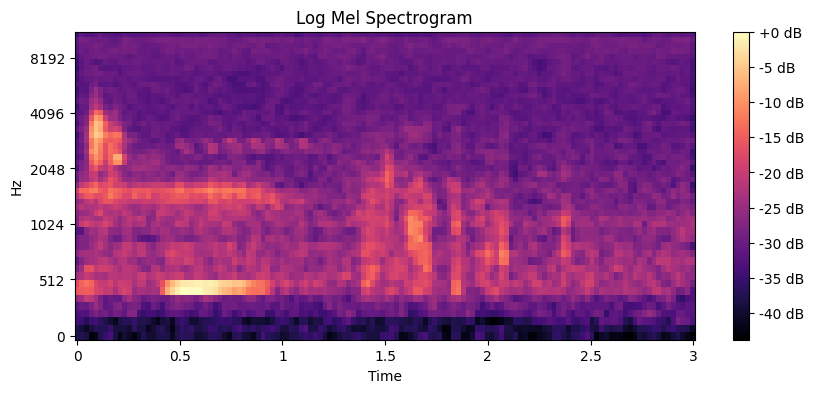

File path: /content/drive/MyDrive/archive/wavfiles/544036-3.wav


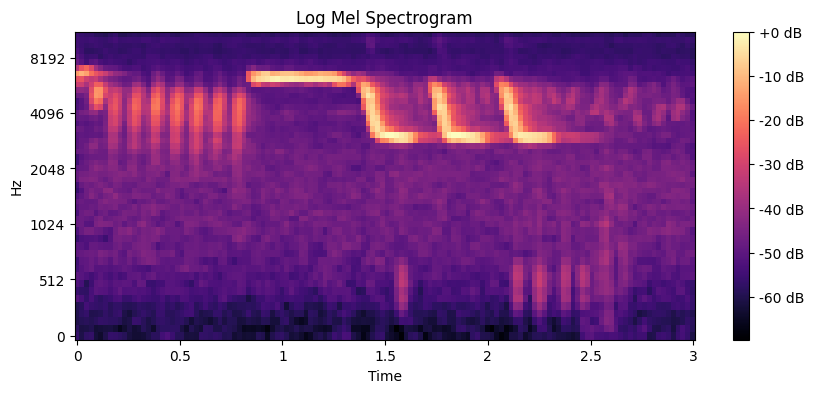

File path: /content/drive/MyDrive/archive/wavfiles/15269-10.wav


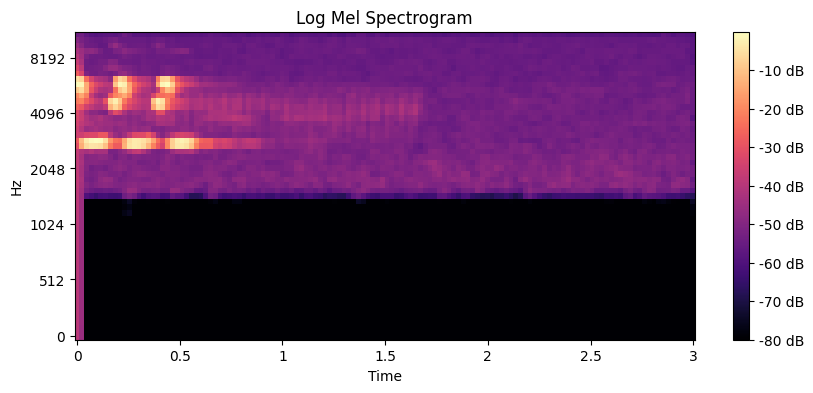

File path: /content/drive/MyDrive/archive/wavfiles/323974-5.wav


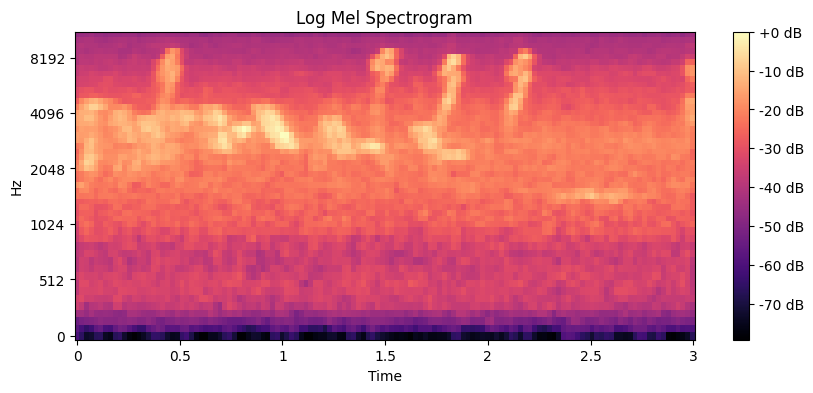

File path: /content/drive/MyDrive/archive/wavfiles/109668-4.wav


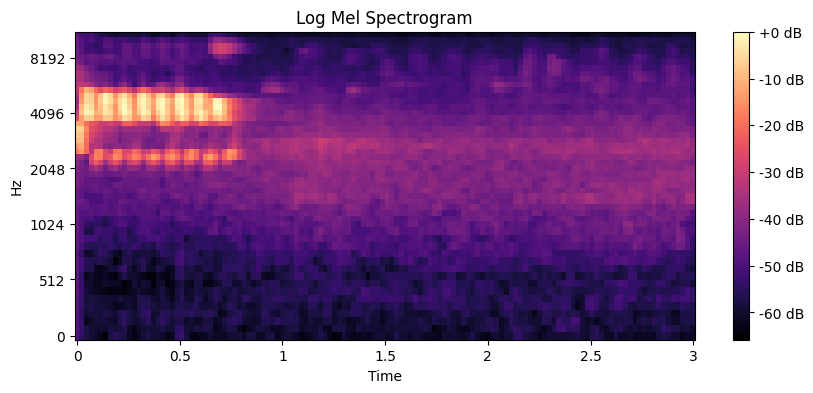

File path: /content/drive/MyDrive/archive/wavfiles/552450-7.wav


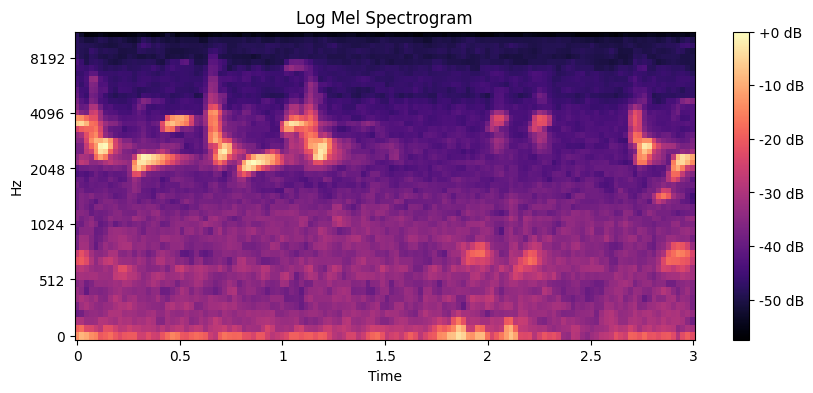

File path: /content/drive/MyDrive/archive/wavfiles/217853-10.wav


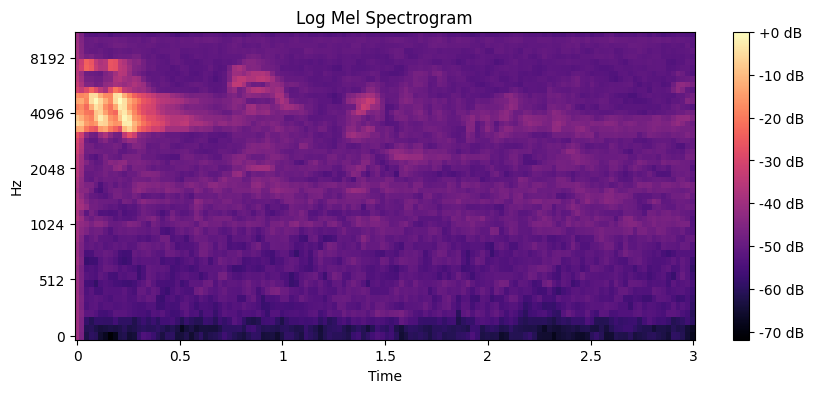

File path: /content/drive/MyDrive/archive/wavfiles/217854-2.wav


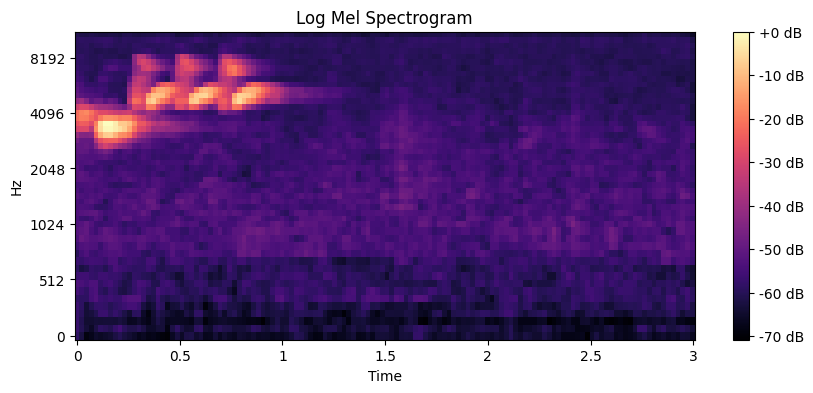

File path: /content/drive/MyDrive/archive/wavfiles/173153-11.wav


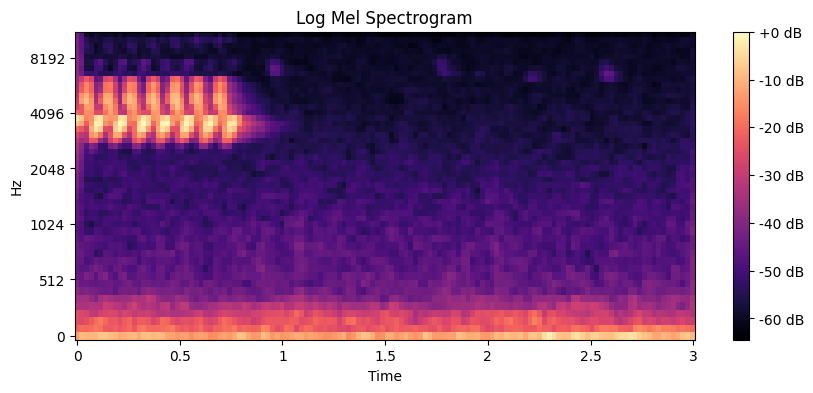

File path: /content/drive/MyDrive/archive/wavfiles/325137-8.wav


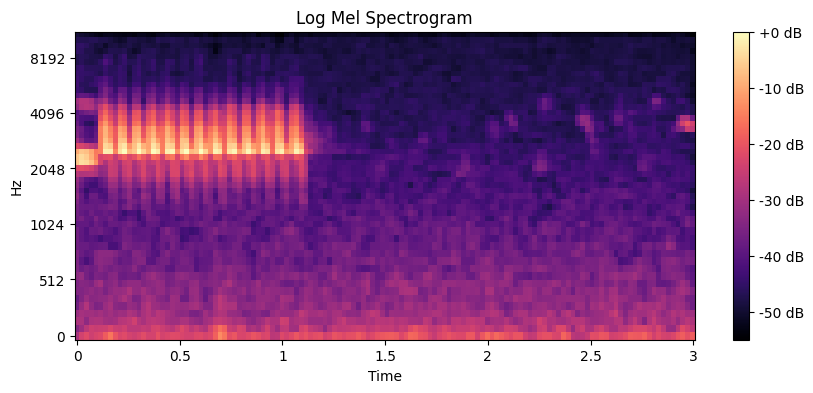

In [80]:
# Function to plot log mel spectrogram
def plot_log_mel_spectrogram(file_path):
    try:
        # Load audio file
        y, sr = librosa.load(file_path)

        # Compute Mel spectrogram
        mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=50, hop_length=512, n_fft=2048)

        # Convert to log scale
        log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)

        # Plot log mel spectrogram
        plt.figure(figsize=(10, 4))
        librosa.display.specshow(log_mel_spectrogram, sr=sr, hop_length=512, x_axis='time', y_axis='mel')
        plt.colorbar(format='%+2.0f dB')
        plt.title('Log Mel Spectrogram')
        plt.show()
    except Exception as e:
        print(f"Error plotting log mel spectrogram: {e}")

# Plot log mel spectrograms for top 10 predictions
for index in top_10_prob_indices:
    file_path = file_paths[index]
    print(f"File path: {file_path}")
    plot_log_mel_spectrogram(file_path)


In [81]:
#bottom ten
bottom_10_prob_indices = np.argsort(np.max(y_prob, axis=1))[:10]
print(bottom_10_prob_indices)

[256 246 478 977 402 294 455 171 754 945]


File path: /content/drive/MyDrive/archive/wavfiles/351078-3.wav


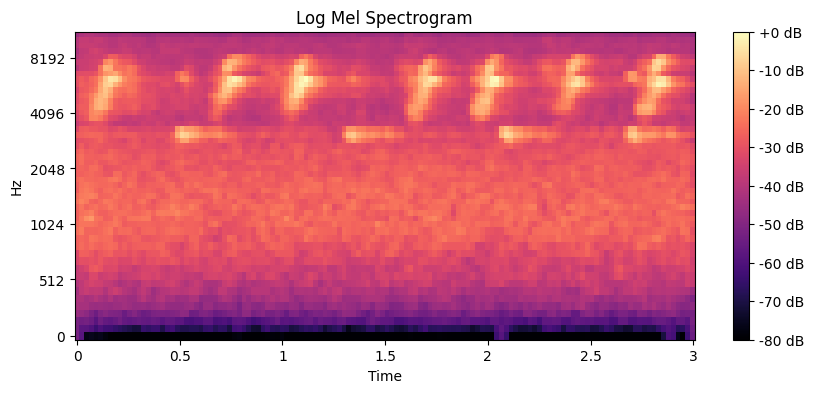

File path: /content/drive/MyDrive/archive/wavfiles/351081-4.wav


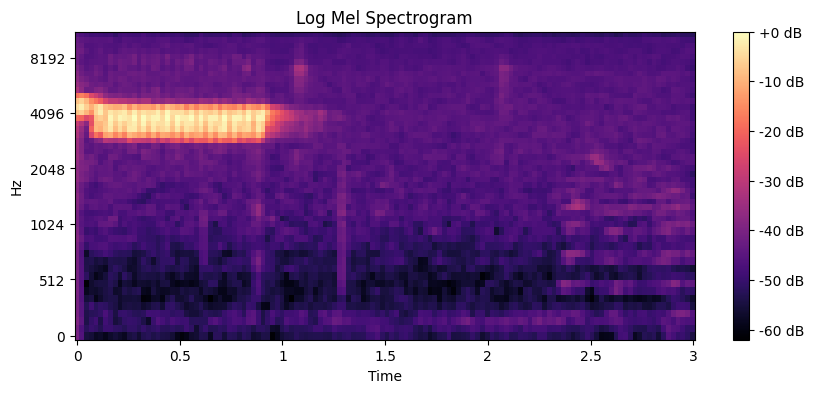

File path: /content/drive/MyDrive/archive/wavfiles/217913-4.wav


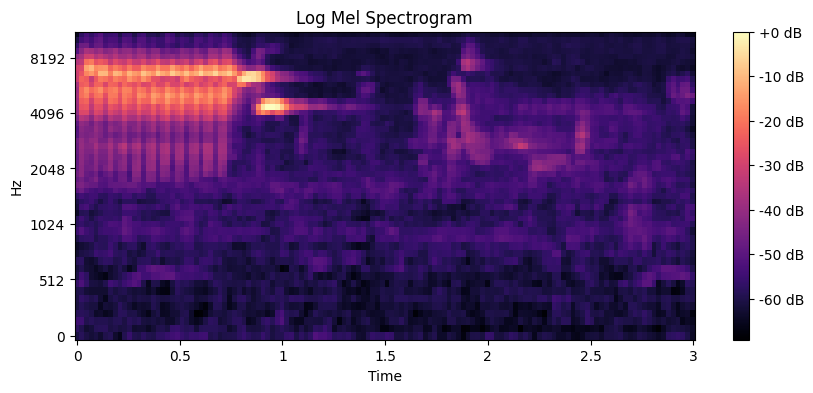

File path: /content/drive/MyDrive/archive/wavfiles/542156-5.wav


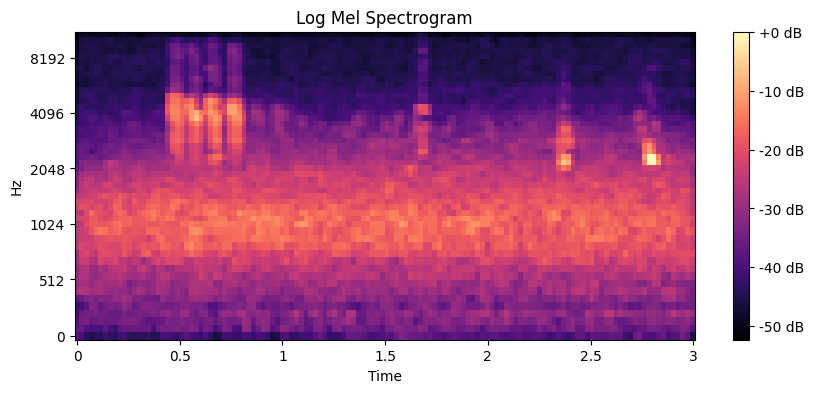

File path: /content/drive/MyDrive/archive/wavfiles/323975-6.wav


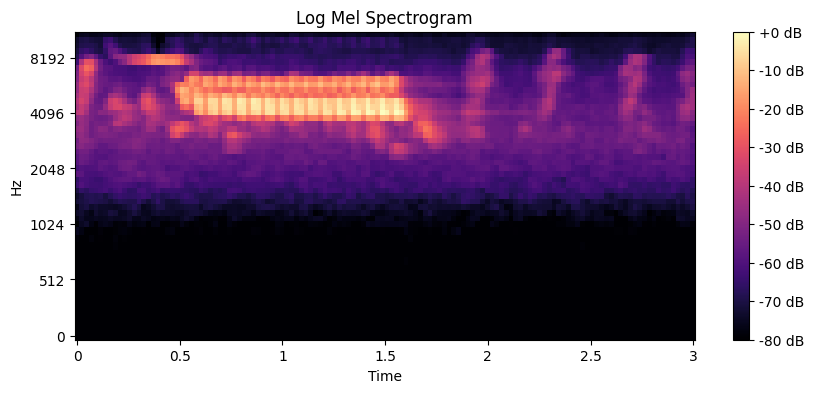

File path: /content/drive/MyDrive/archive/wavfiles/351065-11.wav


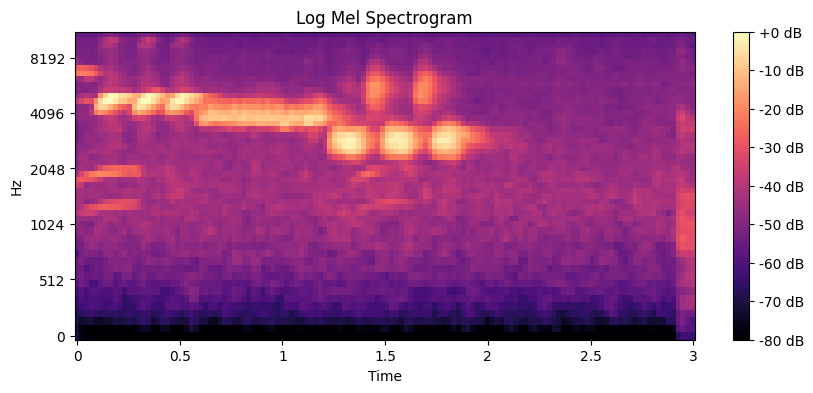

File path: /content/drive/MyDrive/archive/wavfiles/237263-7.wav


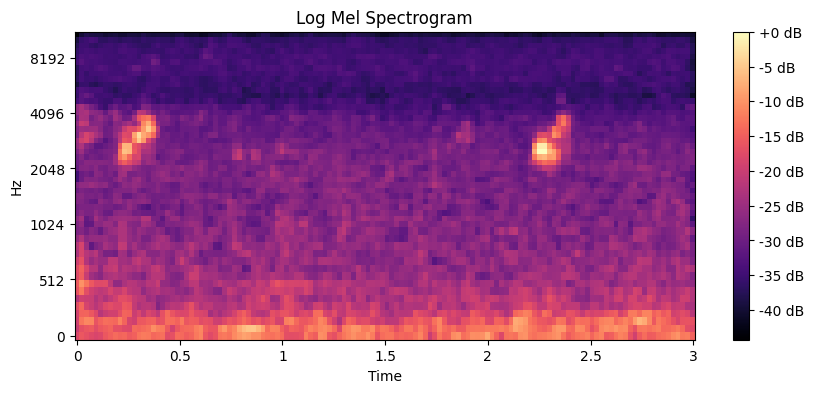

File path: /content/drive/MyDrive/archive/wavfiles/351182-2.wav


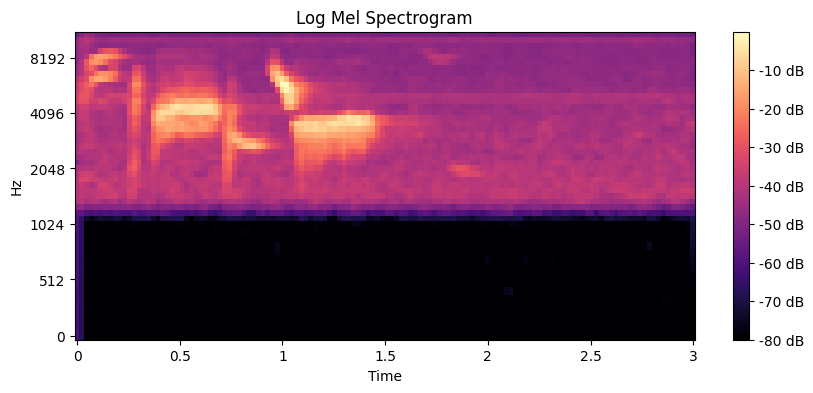

File path: /content/drive/MyDrive/archive/wavfiles/172751-7.wav


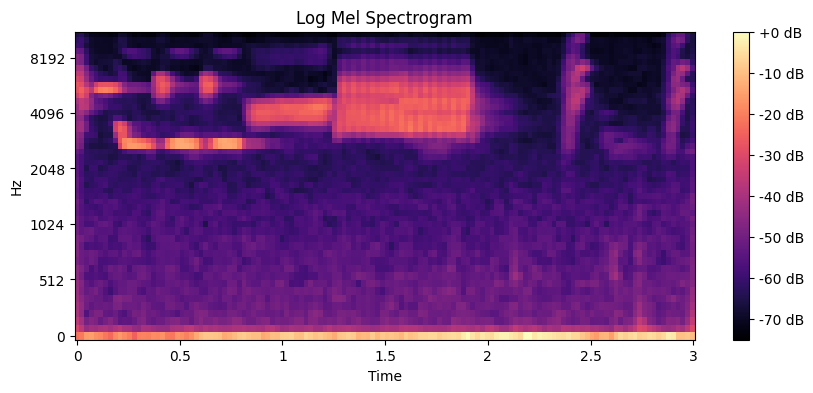

File path: /content/drive/MyDrive/archive/wavfiles/552450-11.wav


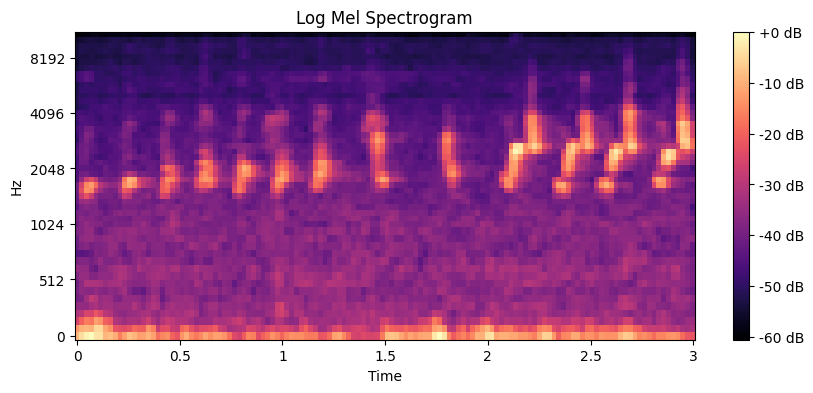

In [82]:
for index in bottom_10_prob_indices:
    file_path = file_paths[index]
    print(f"File path: {file_path}")
    plot_log_mel_spectrogram(file_path)


In [70]:
incorrect_indices = [i for i, (pred, actual) in enumerate(zip(y_pred, y_test)) if pred != actual]
print(incorrect_indices)

[22, 23, 27, 30, 34, 49, 52, 59, 64, 67, 69, 72, 86, 88, 89, 100, 102, 106, 109, 119, 120, 122, 129, 133, 143, 145, 151, 158, 162, 167, 171, 179, 182, 188, 190, 191, 192, 195, 198, 201, 205, 206, 211, 218, 221, 230, 245, 246, 249, 253, 255, 256, 263, 268, 270, 279, 287, 290, 294, 295, 304, 307, 313, 318, 321, 324, 326, 327, 330, 334, 336, 346, 349, 361, 364, 367, 390, 391, 404, 410, 412, 413, 418, 437, 443, 445, 448, 452, 454, 455, 456, 457, 477, 478, 480, 484, 485, 486, 493, 500, 505, 511, 514, 517, 522, 531, 532, 543, 558, 562, 571, 572, 573, 576, 577, 579, 584, 587, 588, 590, 601, 603, 604, 609, 622, 624, 634, 650, 652, 658, 660, 662, 674, 677, 680, 683, 685, 686, 687, 693, 702, 703, 705, 710, 716, 719, 723, 732, 738, 745, 750, 762, 767, 771, 774, 779, 786, 787, 788, 789, 796, 807, 810, 820, 825, 830, 832, 845, 862, 866, 868, 870, 876, 880, 883, 887, 889, 890, 891, 892, 893, 895, 901, 907, 911, 914, 923, 932, 938, 942, 946, 951, 954, 956, 958, 962, 969, 977, 978, 984, 986, 993, 1001

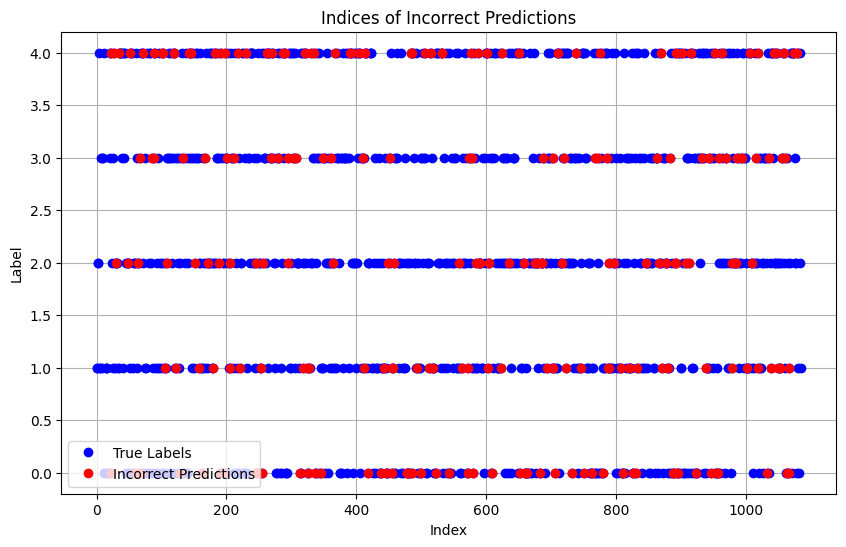

In [83]:
# Plotting the indices of incorrect predictions
plt.figure(figsize=(10, 6))
plt.plot(range(len(y_test)), y_test, 'bo', label='True Labels')
plt.plot(incorrect_indices, [y_test[i] for i in incorrect_indices], 'ro', label='Incorrect Predictions')
plt.title('Indices of Incorrect Predictions')
plt.xlabel('Index')
plt.ylabel('Label')
plt.legend()
plt.grid(True)
plt.show()


In [46]:
# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Mel feature accuracy:", accuracy)

Mel feature accuracy: 0.7944700460829494


In [62]:
print("Classification Report", classification_report(y_test, y_pred, target_names=label_encoder.classes_))

Classification Report               precision    recall  f1-score   support

    bewickii       0.84      0.73      0.78       193
  cardinalis       0.82      0.80      0.81       204
     melodia       0.71      0.84      0.77       243
 migratorius       0.83      0.83      0.83       207
 polyglottos       0.81      0.76      0.79       238

    accuracy                           0.79      1085
   macro avg       0.80      0.79      0.80      1085
weighted avg       0.80      0.79      0.79      1085



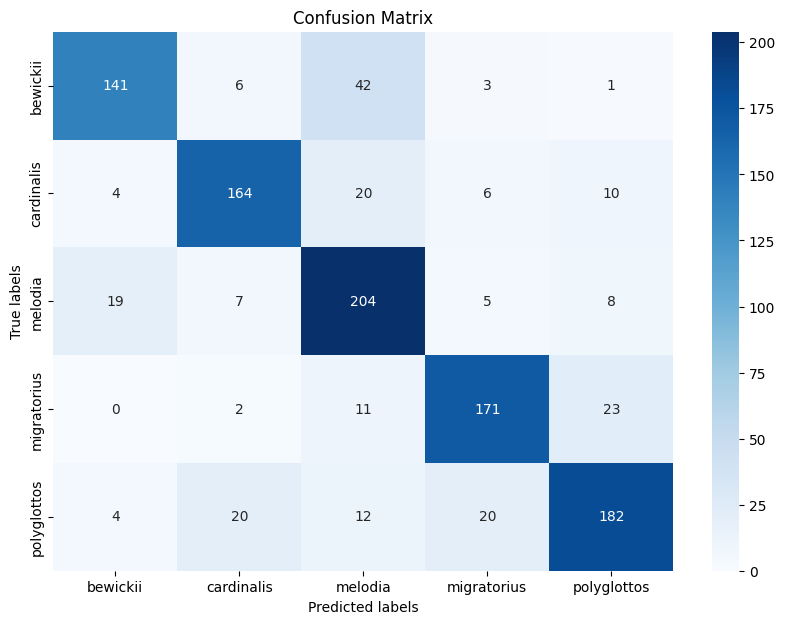

In [48]:
#confusion Matrix
cm = confusion_matrix(y_test, y_pred)

#Plot
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()